# Companion to Featuring Data [#12] - Clustering Part 2

## k-Means and HDBSCAN: A Detailed Comparison

In my previous [blog post](https://featuringdata.substack.com/p/11-clustering-deep-dive-part-1) and [Jupyter notebook](https://github.com/dancapellupo/featuring_data_blog/blob/master/clustering/clustering_part1_kmeans.ipynb), I look at k-Means clustering, and, in particular, how to determine the number of clusters in an automated way. For more background on the k-Means algorithm, which is perhaps the best-known unsupervised learning algorithm, check out this [video from Coursera](https://www.coursera.org/learn/machine-learning/lecture/93VPG/k-means-algorithm).

One of the benefits of the k-Means algorithm is that it is fast, faster than [most other clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html).

This speed is great if you have a large dataset, and you know _a priori_ how many clusters there are in the data. In many cases, we do not know this, and unless the data is only two-dimensional (i.e., only two features), then it is difficult to visualize the data in a way that we can easily verify visually the number of clusters.

Perhaps, even more importantly, what if we know the number of clusters, but the k-Means algorithm clusters the data incorrectly?

In the previous post, I used three or four normally-distributed blobs of points. But, in a more realistic case, what if the clusters have different shapes and the input data are not distributed in a neatly Gaussian way?

An alternative to k-Means clustering is a family of algorithms known as density-based clustering algorithms. One example is DBSCAN, where you define some density that the clusters should have. The algorithm starts at one point and continues adding to the cluster as long as the density meets the threshold set.

So, in this case, instead of having to figure out the number of clusters, one must figure out some reasonable density for the clusters in your dataset, which also is not necessarily always straightforward. You could also have different clusters with different densities.

A relatively recent algorithm that addresses this is HDBSCAN. There is [a great lecture](https://www.youtube.com/watch?v=dGsxd67IFiU) and also [this article](https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e) that describe HDBSCAN and how it works. One does not have to set the density for the algorithm to work, and it attempts to determine the optimal clustering on its own.

And, luckily for us Python users, there is [a Python implementation](https://hdbscan.readthedocs.io/en/latest/index.html) that is fast.

In this notebook, I will explore how HDBSCAN performs on a variety of datasets (I simulate 6 different data sets here, including the 3 from the previous post), and see if it gives an optimal clustering, quickly, without having to do too much adjusting of the model parameters.

Let's explore!

In [1]:
# Import the necessary packages:
import itertools

import numpy as np
from sklearn import cluster, datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# A modified version of the 'kmeans_find_num_clusters' function from the previous post appears in a separate file:
from kmeans_find_num_clusters import kmeans_find_num_clusters

In [2]:
# Load an array of colors for plotting below:
colors = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', '#CC6677', '#882255', '#AA4499', '#77AADD',
          '#88CCAA']

In [3]:
# Function for plotting results:
def plot_clusters(X, cluster_labels, title):
    for ii in np.unique(cluster_labels):
        xx = np.where(cluster_labels == ii)[0]
        color = 'black' if ii == -1 else colors[ii]
        _ = sns.scatterplot(x=X[xx, 0], y=X[xx, 1], color=color, size=2, legend=False)
    _ = plt.title(title, fontsize=13)
    _ = plt.xlabel('X1')
    _ = plt.ylabel('X2')

### Generate Some Data

For this demonstration, I again use the three datasets from the previous post, as well as three more datasets, all using scikit-learn functions for creating simulated data.

I designed the sample data so that visually it should be fairly obvious how many clusters
there are, and then we can see how k-Means and HDBSCAN handles each one below.

As reminder, the three datasets from the previous post are:
1. Three simple, well-separated blobs.
2. The same three blobs from scenario #1, plus an additional blob very close to one
   of the existing ones (but all 4 are still visually separable).
3. The same three blobs from scenario #1, plus a fourth blob very far away.

And here are 3 more scenarios:

4. The three blobs from above, but with different densities.

5. Three blobs that are stretched to be much more of an oval shape.

6. Two concentric circular blobs.

In [4]:
# Create the first three datasets:
blob_centers_orig = np.array([[0, 9], [4.8, 2.5], [-6, 2.5]])
blobs_1 = datasets.make_blobs(n_samples=1500, centers=blob_centers_orig, random_state=42)

blob_centers = np.append(blob_centers_orig, [[4.4, 11.8]], axis=0)
blobs_2 = datasets.make_blobs(n_samples=2000, centers=blob_centers, random_state=42)

blob_centers = np.append(blob_centers_orig, [[5, -30]], axis=0)
blobs_3 = datasets.make_blobs(n_samples=2000, centers=blob_centers, random_state=42)

In [5]:
# New datasets:
# Blobs with different densities:
blob_4a = datasets.make_blobs(n_samples=1000, centers=np.array([[0, 9]]), random_state=42)
blob_4b = datasets.make_blobs(n_samples=200, centers=np.array([[4.8, 2.5]]), random_state=42)
blob_4c = datasets.make_blobs(n_samples=50, centers=np.array([[-6, 2.5]]), random_state=42)
blobs_4 = (np.append(blob_4a[0], blob_4b[0], axis=0), np.append(blob_4a[1], blob_4b[1]))
blobs_4 = (np.append(blobs_4[0], blob_4c[0], axis=0), np.append(blobs_4[1], blob_4c[1]))

# Anisotropicly distributed data:
X, y = datasets.make_blobs(n_samples=1500, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
blobs_aniso = (X_aniso, y)

# Two concentric circles:
noisy_circles = datasets.make_circles(n_samples=1500, factor=.5, noise=.05)

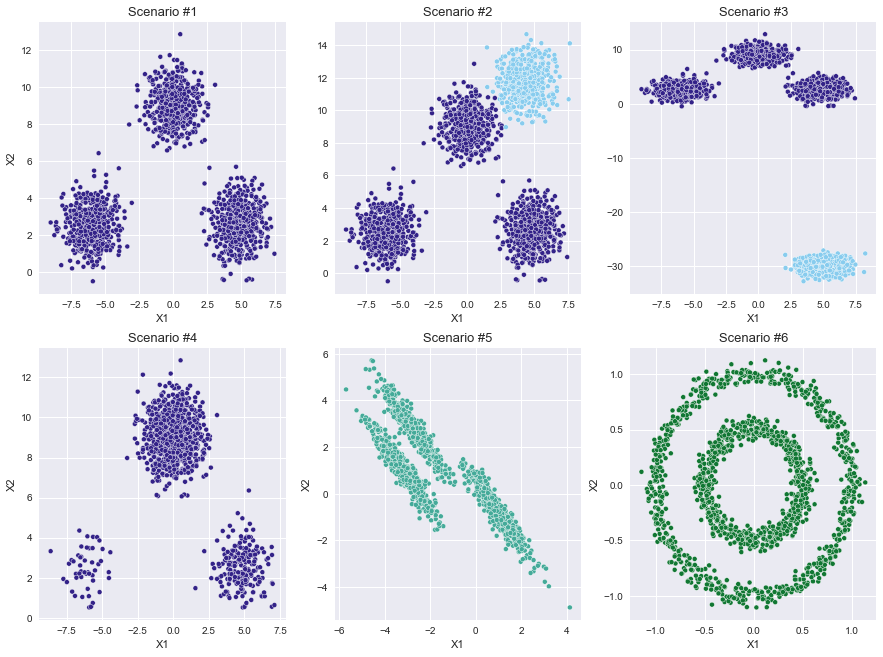

In [6]:
# Plot all the datasets

# Original three blobs:
_ = plt.figure(figsize=(15, 11))

_ = plt.subplot(231)
_ = sns.scatterplot(x=blobs_1[0][:, 0], y=blobs_1[0][:, 1], color=colors[0], size=2, legend=False)
_ = plt.title('Scenario #1', fontsize=13)
_ = plt.xlabel('X1')
_ = plt.ylabel('X2')

_ = plt.subplot(232)
xx = np.where(blobs_2[1] != 3)[0]
_ = sns.scatterplot(x=blobs_2[0][xx, 0], y=blobs_2[0][xx, 1], color=colors[0], size=2, legend=False)
xx = np.where(blobs_2[1] == 3)[0]
_ = sns.scatterplot(x=blobs_2[0][xx, 0], y=blobs_2[0][xx, 1], color=colors[1], size=2, legend=False)
_ = plt.title('Scenario #2', fontsize=13)
_ = plt.xlabel('X1')

_ = plt.subplot(233)
xx = np.where(blobs_3[1] != 3)[0]
_ = sns.scatterplot(x=blobs_3[0][xx, 0], y=blobs_3[0][xx, 1], color=colors[0], size=2, legend=False)
xx = np.where(blobs_3[1] == 3)[0]
_ = sns.scatterplot(x=blobs_3[0][xx, 0], y=blobs_3[0][xx, 1], color=colors[1], size=2, legend=False)
_ = plt.title('Scenario #3', fontsize=13)
_ = plt.xlabel('X1')

# ---

# Three new datasets:
_ = plt.subplot(234)
_ = sns.scatterplot(x=blobs_4[0][:, 0], y=blobs_4[0][:, 1], color=colors[0], size=2, legend=False)
_ = plt.title('Scenario #4', fontsize=13)
_ = plt.xlabel('X1')
_ = plt.ylabel('X2')

_ = plt.subplot(235)
_ = sns.scatterplot(x=blobs_aniso[0][:, 0], y=blobs_aniso[0][:, 1], color=colors[2], size=2, legend=False)
_ = plt.title('Scenario #5', fontsize=13)
_ = plt.xlabel('X1')
_ = plt.ylabel('X2')

_ = plt.subplot(236)
_ = sns.scatterplot(x=noisy_circles[0][:, 0], y=noisy_circles[0][:, 1], color=colors[3], size=2, legend=False)
_ = plt.title('Scenario #6', fontsize=13)
_ = plt.xlabel('X1')
_ = plt.ylabel('X2')

### How does k-Means Perform on the New Datasets?

I plot here again the best clustering found for the first three scenarios from the previous post.

For the three new scenarios, I run 'kmeans_find_num_clusters' and use the optimal cluster number based on the silhouette coefficient.

Scenario #4
Best cluster number (by elbow): 3
Best cluster number (by gap_stat): 3
Best cluster number (by pred_strength): 3
Best cluster number (by silhouette): 3

Scenario #5
Best cluster number (by elbow): 3
Best cluster number (by gap_stat): 6
Best cluster number (by pred_strength): 6
Best cluster number (by silhouette): 2

Scenario #6
Best cluster number (by elbow): 4
Best cluster number (by gap_stat): 3
Best cluster number (by pred_strength): 1
Best cluster number (by silhouette): 10



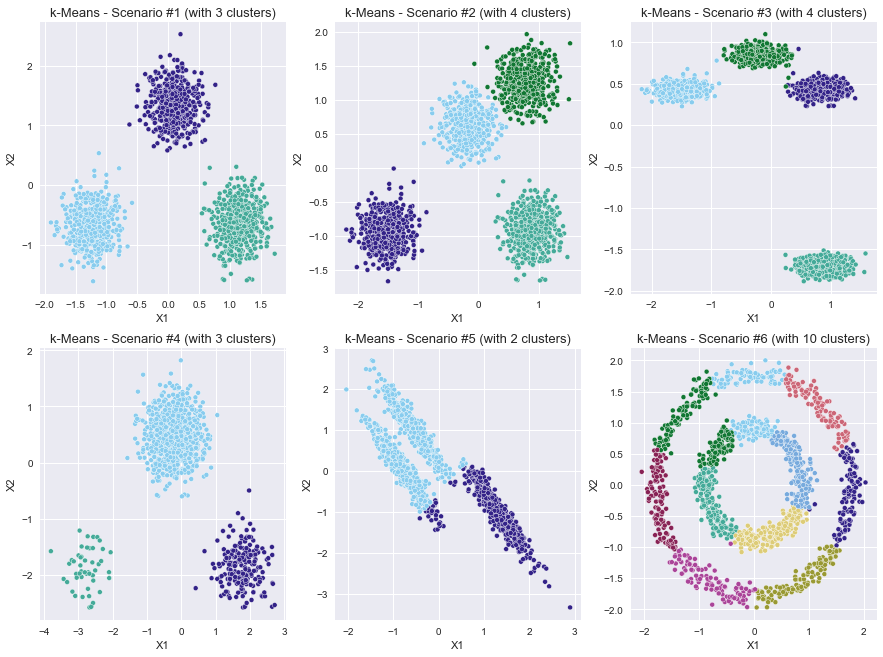

In [7]:
# Set parameters to use below:
n_clusters_min = 1
n_clusters_max = 10

# Plot k-Means results for all 6 datasets using best cluster number from silhouette coefficient

_ = plt.figure(figsize=(15, 11))

# --------------------------
# First 3 Scenarios:

_ = plt.subplot(231)

# Load the data and scale it:
X, y = blobs_1
X = StandardScaler().fit_transform(X)

model = cluster.KMeans(n_clusters=3, random_state=42, verbose=0)
model.fit(X)

plot_clusters(X, model.labels_, 'k-Means - Scenario #1 (with 3 clusters)')

_ = plt.subplot(232)

# Load the data and scale it:
X, y = blobs_2
X = StandardScaler().fit_transform(X)

model = cluster.KMeans(n_clusters=4, random_state=42, verbose=0)
model.fit(X)

plot_clusters(X, model.labels_, 'k-Means - Scenario #2 (with 4 clusters)')

_ = plt.subplot(233)

# Load the data and scale it:
X, y = blobs_3
X = StandardScaler().fit_transform(X)

model = cluster.KMeans(n_clusters=4, random_state=42, verbose=0)
model.fit(X)

plot_clusters(X, model.labels_, 'k-Means - Scenario #3 (with 4 clusters)')

# --------------------------
# New 3 Scenarios:

_ = plt.subplot(234)

print('Scenario #4')

# Load the data and scale it:
X, y = blobs_4
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_elbow, best_clust_num = kmeans_find_num_clusters(X, method='elbow',
                                                              n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
results_list_gap, best_clust_num = kmeans_find_num_clusters(X, method='gap_stat',
                                                            n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
results_list_predstr, best_clust_num = kmeans_find_num_clusters(X, method='pred_strength',
                                                                n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
results_list_silh, best_clust_num = kmeans_find_num_clusters(X, method='silhouette',
                                                             n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print()

# Plot the results:
model = cluster.KMeans(n_clusters=best_clust_num, random_state=42, verbose=0)
model.fit(X)

plot_clusters(X, model.labels_, 'k-Means - Scenario #4 (with {} clusters)'.format(best_clust_num))

# ---

_ = plt.subplot(235)

print('Scenario #5')

# Load the data and scale it:
X, y = blobs_aniso
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_elbow, best_clust_num = kmeans_find_num_clusters(X, method='elbow',
                                                              n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
results_list_gap, best_clust_num = kmeans_find_num_clusters(X, method='gap_stat',
                                                            n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
results_list_predstr, best_clust_num = kmeans_find_num_clusters(X, method='pred_strength',
                                                                n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
results_list_silh, best_clust_num = kmeans_find_num_clusters(X, method='silhouette',
                                                             n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print()

# Plot the results:
model = cluster.KMeans(n_clusters=best_clust_num, random_state=42, verbose=0)
model.fit(X)

plot_clusters(X, model.labels_, 'k-Means - Scenario #5 (with {} clusters)'.format(best_clust_num))

# ---

_ = plt.subplot(236)

print('Scenario #6')

# Load the data and scale it:
X, y = noisy_circles
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_elbow, best_clust_num = kmeans_find_num_clusters(X, method='elbow',
                                                              n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
results_list_gap, best_clust_num = kmeans_find_num_clusters(X, method='gap_stat',
                                                            n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
results_list_predstr, best_clust_num = kmeans_find_num_clusters(X, method='pred_strength',
                                                                n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
results_list_silh, best_clust_num = kmeans_find_num_clusters(X, method='silhouette',
                                                             n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print()

# Plot the results:
model = cluster.KMeans(n_clusters=best_clust_num, random_state=42, verbose=0)
model.fit(X)

plot_clusters(X, model.labels_, 'k-Means - Scenario #6 (with {} clusters)'.format(best_clust_num))

### Where k-Means Breaks Down

One problem with k-Means is that it will force a clustering, even if it doesn't make sense.

This is evident in Scenarios #5 and #6 above, where the clusters are not blobs with normally distributed data.

For Scenario #5, with the 3 elongated blobs, the silhouette coefficient indicates that 2 clusters is the right number, and the prediction strength indicates 6 clusters.

For Scenario #6, with the concentric circular clusters, the silhouette coefficient indicates that 10 clusters is the right number, while the prediction strength indicates there is just 1 cluster.

By eye, it looks like there are 3 clusters in Scenario #5 and 2 clusters in Scenario #6. What if we chose those cluster numbers and re-run k-Means:

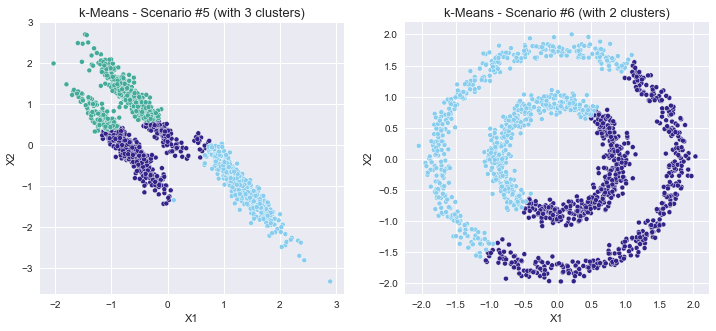

In [8]:
_ = plt.figure(figsize=(12, 5))

_ = plt.subplot(121)

# Load the data and scale it:
X, y = blobs_aniso
X = StandardScaler().fit_transform(X)

# Plot the results:
model = cluster.KMeans(n_clusters=3, random_state=42, verbose=0)
model.fit(X)

plot_clusters(X, model.labels_, 'k-Means - Scenario #5 (with {} clusters)'.format(3))

# ---

_ = plt.subplot(122)

# Load the data and scale it:
X, y = noisy_circles
X = StandardScaler().fit_transform(X)

# Plot the results:
model = cluster.KMeans(n_clusters=2, random_state=42, verbose=0)
model.fit(X)

plot_clusters(X, model.labels_, 'k-Means - Scenario #6 (with {} clusters)'.format(2))

Clearly, this is problematic if we set-up an automated clustering routine that uses one of the above methods for finding the ideal number of clusters, and just going with that.

Maybe a different algorithm can help here.

### HDBSCAN: Can it Automatically Find the Right Number of Clusters?

First, I want to see what happens if I just run HDBSCAN on all six scenarios, using the default parameters.

Scenario #1 - HDBSCAN Clusters:
[-1  0  1  2]
[  1 500 500 499]

Scenario #2 - HDBSCAN Clusters:
[-1  0  1  2]
[  1 500 500 999]

Scenario #3 - HDBSCAN Clusters:
[-1  0  1  2  3  4]
[ 17 500 498 500   6 479]

Scenario #4 - HDBSCAN Clusters:
[0 1 2]
[  50  200 1000]

Scenario #5 - HDBSCAN Clusters:
[-1  0  1  2  3  4  5]
[ 79 487 464   6 442  14   8]

Scenario #6 - HDBSCAN Clusters:
[0 1]
[750 750]


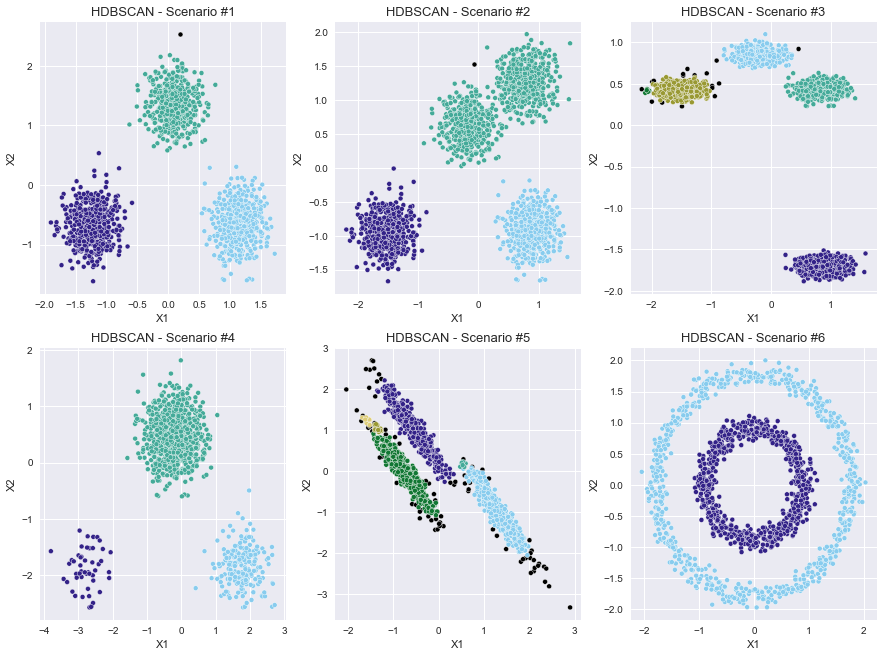

In [9]:
# Plot HDBSCAN results for all 6 datasets using the default model parameters

_ = plt.figure(figsize=(15, 11))

# --------------------------
# First 3 Scenarios:

_ = plt.subplot(231)

# Load the data and scale it:
X, y = blobs_1
X = StandardScaler().fit_transform(X)

model = hdbscan.HDBSCAN()
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('Scenario #1 - HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #1')

_ = plt.subplot(232)

# Load the data and scale it:
X, y = blobs_2
X = StandardScaler().fit_transform(X)

model = hdbscan.HDBSCAN()
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('\nScenario #2 - HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #2')

_ = plt.subplot(233)

# Load the data and scale it:
X, y = blobs_3
X = StandardScaler().fit_transform(X)

model = hdbscan.HDBSCAN()
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('\nScenario #3 - HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #3')

# --------------------------
# New 3 Scenarios:

_ = plt.subplot(234)

# Load the data and scale it:
X, y = blobs_4
X = StandardScaler().fit_transform(X)

model = hdbscan.HDBSCAN()
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('\nScenario #4 - HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #4')

# ---

_ = plt.subplot(235)

# Load the data and scale it:
X, y = blobs_aniso
X = StandardScaler().fit_transform(X)

model = hdbscan.HDBSCAN()
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('\nScenario #5 - HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #5')

# ---

_ = plt.subplot(236)

# Load the data and scale it:
X, y = noisy_circles
X = StandardScaler().fit_transform(X)

model = hdbscan.HDBSCAN()
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('\nScenario #6 - HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #6')

The results above aren't too bad, considering that I made no manual adjustments to the default parameters for the HDBSCAN model.

It seems here that HDBSCAN can handle a variety of shapes, from the normally distributed blobs to the concentric circular clusters.

The one scenario where it appears to really have broken down is Scenario #2, where the two blobs that are very close together were merged into one cluster. Also, in Scenarios #3 and #5, a couple, very small clusters were added, where I was not expecting to see additional clusters.

### Adjusting HDBSCAN Parameters

There a few parameters for HDBSCAN that can be adjusted:

1. [`min_cluster_size`](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#selecting-min-cluster-size)
2. [`min_samples`](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#selecting-min-samples)
3. [`cluster_selection_epsilon`](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#selecting-cluster-selection-epsilon)

I will try adjusting just `min_cluster_size` and `min_samples` and see how the results look.

In order to do this in an automated way, I wrote the function below that runs HDBSCAN with different pairs of values for two parameters. In order to determine the best pair of parameters, I investigate using the silhouette coefficient, as well as a metric that is used for density-based clustering algorithms called [Density Based Cluster Validity (DBCV)](https://github.com/christopherjenness/DBCV#what-is-dbcv). Essentially, the DBCV compares the density within clusters to the density between the clusters. A good clustering result should have high densities within clusters, and lower densities in between.

In [10]:
def hdbscan_hyperparam_search(X, method='silhouette', verbose=True):
    
    min_cluster_size_list = [5, 10, 20]
    min_samples_list = [None, 5, 10]
    
    # Initialize list for results:
    results_list = []
    
    for (min_cluster_size, min_samples) in itertools.product(min_cluster_size_list, min_samples_list):
        
        if method == 'silhouette':
            # Run HDBSCAN:
            model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True).fit(X)
            
            # Calculate and save the Silhouette score for the current clustering:
            xx = np.where(model.labels_ != -1)[0]
            X_clustered, cluster_labels = X[xx], model.labels_[xx]
            
            silh_coef = metrics.silhouette_score(X_clustered, cluster_labels, metric='euclidean')
            
            num_outliers = np.where(model.labels_ == -1)[0].size
            num_clusters = np.unique(cluster_labels).size
            
            results_list.append(silh_coef)
            
            if verbose:
                space_1 = ' ' if min_cluster_size < 10 else ''
                if min_samples is None:
                    space_2 = ''
                elif min_samples >= 10:
                    space_2 = '  '
                else:
                    space_2 = '   '
                print(min_cluster_size, space_1, min_samples, space_2, ':', '{:.3f} {:.3f}'.format(silh_coef, model.relative_validity_), num_clusters, num_outliers)
        
        elif method == 'DBCV':
            # Run HDBSCAN:
            model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True).fit(X)
            
            results_list.append(model.relative_validity_)
    
    best_params_index = np.nanargmax(np.array(results_list))
    best_min_cluster_size, best_min_samples = list(itertools.product(min_cluster_size_list, min_samples_list))[best_params_index]
    
    print('Best cluster params (by {}): min_cluster_size={} and min_samples={}'.format(method, best_min_cluster_size, best_min_samples))

    return results_list, best_min_cluster_size, best_min_samples

Scenario #1
5   None  : 0.789 0.197 3 1
5   5     : 0.789 0.197 3 1
5   10    : 0.790 0.267 3 1
10  None  : 0.790 0.267 3 1
10  5     : 0.789 0.197 3 1
10  10    : 0.790 0.267 3 1
20  None  : 0.789 0.335 3 0
20  5     : 0.789 0.197 3 1
20  10    : 0.790 0.267 3 1
Best cluster params (by silhouette): min_cluster_size=5 and min_samples=10

HDBSCAN Clusters:
[-1  0  1  2]
[  1 500 499 500]

Scenario #2
5   None  : 0.704 0.103 3 1
5   5     : 0.704 0.103 3 1
5   10    : 0.738 0.307 4 75
10  None  : 0.738 0.307 4 75
10  5     : 0.630 0.559 5 95
10  10    : 0.738 0.307 4 75
20  None  : 0.740 0.405 4 90
20  5     : 0.734 0.347 4 51
20  10    : 0.738 0.307 4 75
Best cluster params (by silhouette): min_cluster_size=20 and min_samples=None

HDBSCAN Clusters:
[-1  0  1  2  3]
[ 90 500 500 458 452]

Scenario #3
5   None  : 0.726 0.223 5 17
5   5     : 0.726 0.223 5 17
5   10    : 0.796 0.220 4 2
10  None  : 0.796 0.220 4 2
10  5     : 0.797 0.454 4 2
10  10    : 0.796 0.220 4 2
20  None  : 0.801 0

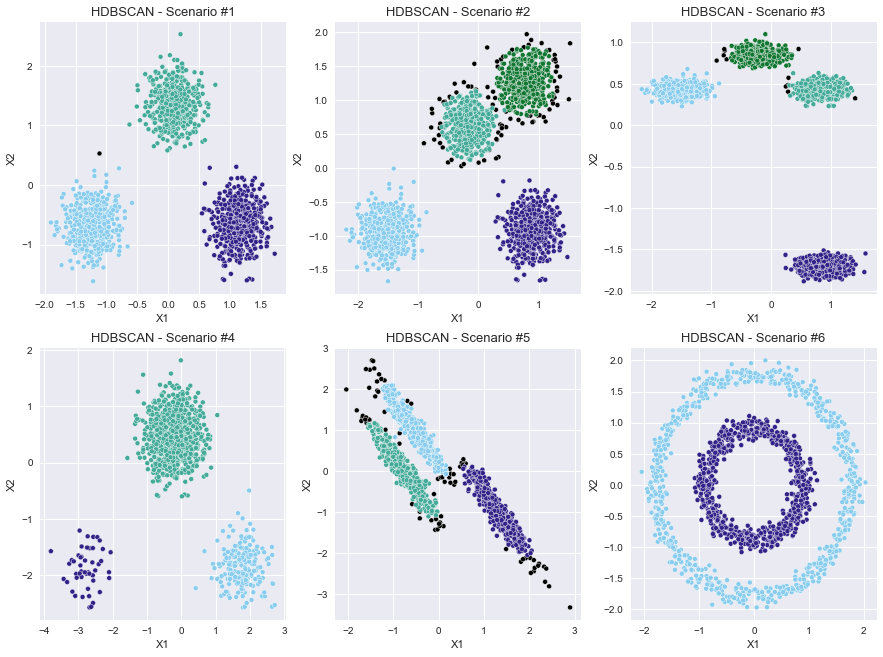

In [11]:
# Plot HDBSCAN results for all 6 datasets using best cluster number from silhouette coefficient

_ = plt.figure(figsize=(15, 11))

# --------------------------
# First 3 Scenarios:

_ = plt.subplot(231)

print('Scenario #1')

# Load the data and scale it:
X, y = blobs_1
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_silh, best_min_cluster_size, best_min_samples = hdbscan_hyperparam_search(X, method='silhouette')
print()

# Plot the results:
model = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #1')

# ---

_ = plt.subplot(232)

print('\nScenario #2')

# Load the data and scale it:
X, y = blobs_2
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_silh, best_min_cluster_size, best_min_samples = hdbscan_hyperparam_search(X, method='silhouette')
print()

# Plot the results:
model = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #2')

# ---

_ = plt.subplot(233)

print('\nScenario #3')

# Load the data and scale it:
X, y = blobs_3
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_silh, best_min_cluster_size, best_min_samples = hdbscan_hyperparam_search(X, method='silhouette')
print()

# Plot the results:
model = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #3')

# --------------------------
# New 3 Scenarios:

_ = plt.subplot(234)

print('\nScenario #4')

# Load the data and scale it:
X, y = blobs_4
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_silh, best_min_cluster_size, best_min_samples = hdbscan_hyperparam_search(X, method='silhouette')
print()

# Plot the results:
model = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #4')

# ---

_ = plt.subplot(235)

print('\nScenario #5')

# Load the data and scale it:
X, y = blobs_aniso
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_silh, best_min_cluster_size, best_min_samples = hdbscan_hyperparam_search(X, method='silhouette')
print()

# Plot the results:
model = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #5')

# ---

_ = plt.subplot(236)

print('\nScenario #6')

# Load the data and scale it:
X, y = noisy_circles
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_silh, best_min_cluster_size, best_min_samples = hdbscan_hyperparam_search(X, method='silhouette')
print()

# Plot the results:
model = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #6')

Looking at the results above, using the silhouette coefficient seems to give good results. The numbers of clusters look right, and the algorithm handles the different shapes well.

What about this other metric, the Density Based Cluster Validity (DBCV)?

In some cases, this metric gives similar results as the silhouette coefficient, in terms of comparing how different parameters affect the resulting clustering. However, there are two scenarios above where I think the silhouette coefficient gives better results.

In Scenario #2, where I generated four distinct blobs, the run of HDBSCAN that gives the highest DBCV score results in 4 large clusters, which a fifth small cluster.

Similarly, in Scenario #5, an extra small cluster appears.

I visualize these two scenarios here using the model parameters that give the highest DBCV score.

Scenario #2
Best cluster params (by DBCV): min_cluster_size=10 and min_samples=5

HDBSCAN Clusters:
[-1  0  1  2  3  4]
[ 95 500 500 470  10 425]

Scenario #5
Best cluster params (by DBCV): min_cluster_size=5 and min_samples=10

HDBSCAN Clusters:
[-1  0  1  2  3]
[ 94 479 482   6 439]


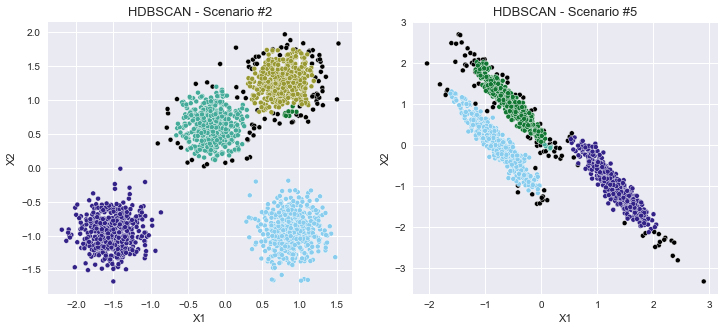

In [12]:
# Plot HDBSCAN results for all 6 datasets using best cluster number from "density based cluster validity"

_ = plt.figure(figsize=(12, 5))

# ---

_ = plt.subplot(121)

print('Scenario #2')

# Load the data and scale it:
X, y = blobs_2
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_silh, best_min_cluster_size, best_min_samples = hdbscan_hyperparam_search(X, method='DBCV')
print()

# Plot the results:
model = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #2')

# ---

_ = plt.subplot(122)

print('\nScenario #5')

# Load the data and scale it:
X, y = blobs_aniso
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_silh, best_min_cluster_size, best_min_samples = hdbscan_hyperparam_search(X, method='DBCV')
print()

# Plot the results:
model = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples)
model.fit(X)

cluster_count = np.unique(model.labels_, return_counts=True)
print('HDBSCAN Clusters:')
print(cluster_count[0])
print(cluster_count[1])

plot_clusters(X, model.labels_, 'HDBSCAN - Scenario #5')

### How Long Does it Take to Run Each Technique?

In [13]:
# Load the data and scale it:
X, y = blobs_4
X = StandardScaler().fit_transform(X)

print('Time to run k-Means 9 times in order to find optimal silhouette coefficient:')
%timeit results_list_silh, best_clust_num = kmeans_find_num_clusters(X, method='silhouette', n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)

print('\nTime to run HDBSCAN 9 times in order to find optimal silhouette coefficient:')
%timeit results_list_silh, best_min_cluster_size, best_min_samples = hdbscan_hyperparam_search(X, method='silhouette', verbose=False)

Time to run k-Means 9 times in order to find optimal silhouette coefficient:
Best cluster number (by silhouette): 3
Best cluster number (by silhouette): 3
Best cluster number (by silhouette): 3
Best cluster number (by silhouette): 3
Best cluster number (by silhouette): 3
Best cluster number (by silhouette): 3
Best cluster number (by silhouette): 3
Best cluster number (by silhouette): 3
911 ms ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to run HDBSCAN 9 times in order to find optimal silhouette coefficient:
Best cluster params (by silhouette): min_cluster_size=5 and min_samples=None
Best cluster params (by silhouette): min_cluster_size=5 and min_samples=None
Best cluster params (by silhouette): min_cluster_size=5 and min_samples=None
Best cluster params (by silhouette): min_cluster_size=5 and min_samples=None
Best cluster params (by silhouette): min_cluster_size=5 and min_samples=None
Best cluster params (by silhouette): min_cluster_size=5 and min_samples=None
Best

Interestingly, it took significantly less time to run HDBSCAN than k-Means on this dataset.

### Reviewing the Results

In my previous post, I compared different methods for finding the optimal number of clusters when running the k-Means algorithm. In that post, all of the clusters were round, normally distributed blobs of points. In this post, I look at three more datasets, that include different blob shapes, and k-Means does not give good results on these different shapes. The k-Means algorithm will still give a result, and, because we are working in just two dimensions here, we can see visually that the clustering does not look right. But, what about more complex datasets where it is harder to visualize all of the data points?

HDBSCAN performs much better. While running with the default parameters generally works okay for the datasets here, we can get better results by adjusting two of the parameters and optimizing the silhouette coefficient.

It should be noted that with the shapes in Scenarios #5 and #6, the silhouette coefficient value is relatively low, and there may be cases where this metric does not give the best results. However, the Density Based Cluster Validity metric did not perform any better, and in a couple cases, gave sub-optimal results. Perhaps, some combination of these two metrics could be used. It would be worth exploring with more complex datasets, with unusual blob shapes.

The last thing I look at is speed. The k-Means algorithm is popular, in part, because it is fast. However, the Python implementation of HDBSCAN used here is even faster than k-Means, taking 510 ms to run the algorithm 9 times as part of the optimal parameter search, compared to 910 ms for k-Means.

In summary, it appears that HDBSCAN should be the go-to clustering algorithm, but some adjusting of the input parameters may be necessary to get the optimal results.